In [63]:
# import labraries
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u
from astropy.constants import m_e, c, hbar, M_sun, G, m_n

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})



Hence, we can approximate for the two different regimes
$$
\epsilon(p) \simeq A_\text{NR}p^{3/5}+ A_\text{R}p^{3/4}, \quad A_\text{NR} = (K_\text{NR})^{-3/5}, A_\text{R} = (K_\text{R})^{-3/4}
$$


The first term dominates for low pressures, when $k_F\ll m_e$ and the second for $k_F\gg m_e$.

Solving the TOV equations for different Equations of state


# TOV Equations

$$
\begin{aligned}
\frac{dp}{dr}&= -\frac{G \epsilon(r)M(r)}{c^2r^2}\bigg(1+ \frac{p(r)}{e(r)}\bigg)\bigg(1+ \frac{4\pi r^3p(r)}{M(r)c^2}\bigg)\bigg(1-\frac{2GM(r)}{c^2r}\bigg)^{-1}\\

\frac{dM}{dr}&= \frac{4 \pi r^2 \epsilon (r)}{c^2}

\end{aligned}
$$


# Electron-degenerated matter (White Dwarf)


Equation of state:

$$
p(\epsilon) = K \epsilon^\gamma
$$
Approximate solutions for two different regimes: (NonRel.  $k_F\ll m_e$, Rel. $k_F\gg m_e$.):
$$
K_\text{NR} = \frac{\hbar^2}{15\pi^2m_e}\bigg(\frac{3 \pi^2 Z}{Am_Nc^2}\bigg)^{5/3} \qquad K_\text{R} = \frac{\hbar \ c}{15\pi^2}\bigg(\frac{3 \pi^2 Z}{Am_Nc^2}\bigg)^{4/3} 
$$
$$
\gamma_\text{NR} = \frac{5}{3} \qquad \gamma_\text{R} = \frac{4}{3} 
$$



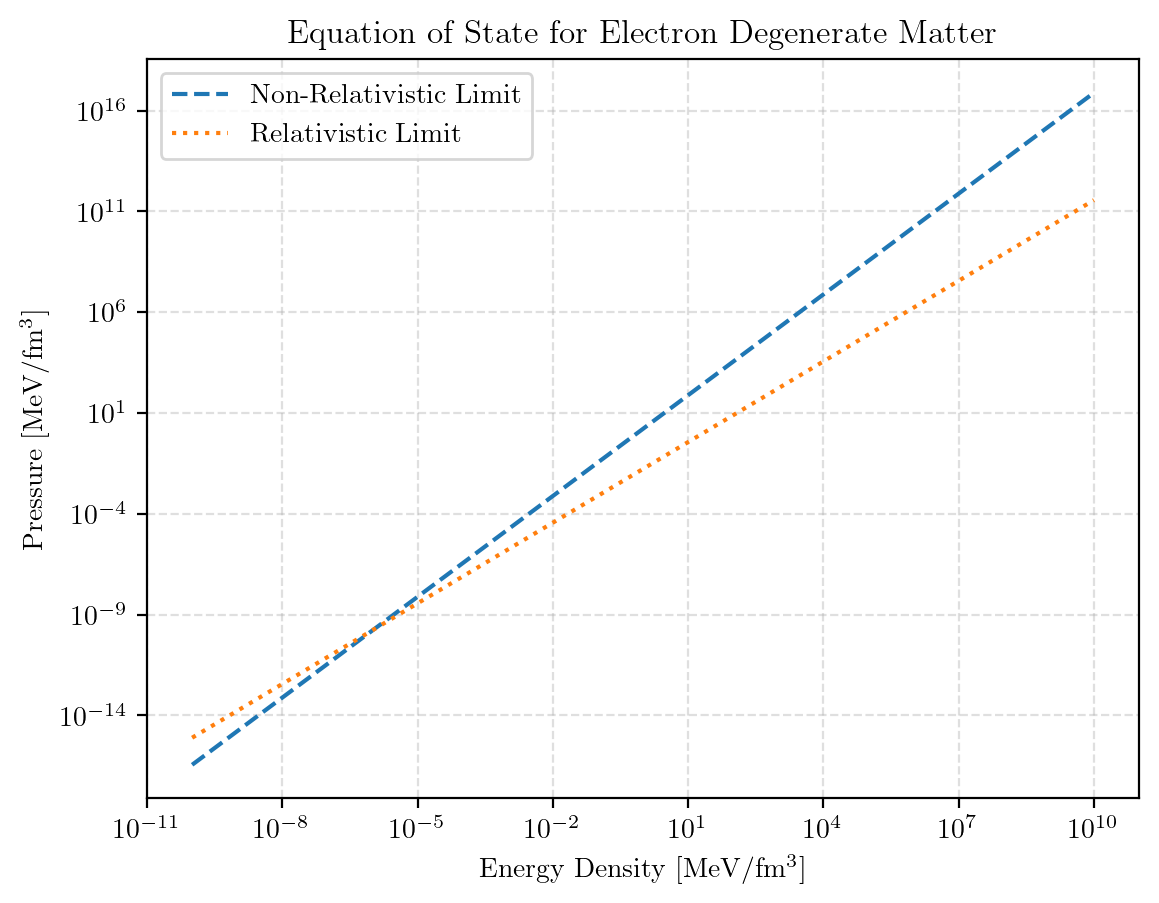

In [2]:
AZ = 1 # A/Z 
K_R  = (hbar * c / 12 / np.pi**2 * ((3 * np.pi**2)/ (931.5 * u.MeV * AZ)) **(4/3)).to('fm / MeV**(1/3)')
K_NR = (hbar ** 2 / 15 / np.pi**2 / m_e * ((3 * np.pi**2)/ (931.5 * u.MeV * AZ)) **(5/3)).to('fm2 / MeV**(2/3)')

def p_R_EOS_electron_matter(e):
    return K_R  * e ** (4/3)

def p_NR_EOS_electron_matter(e):
    return K_NR * e ** (5/3)

e_vals = np.logspace(-10, 10, 1000) * u.MeV / u.fm**3
p_NR_vals = p_NR_EOS_electron_matter(e_vals)
p_R_vals  = p_R_EOS_electron_matter(e_vals)

plt.loglog(e_vals,p_NR_vals, '--', label='Non-Relativistic Limit')
plt.loglog(e_vals, p_R_vals, ':', label='Relativistic Limit')
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.title('Equation of State for Electron Degenerate Matter')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()



We must solve the TOV using dimensionless $\bar p, \bar M$, defined as
$$
\begin{aligned}
p &= \epsilon_0 \bar p\\
\epsilon &= \epsilon_0 \bar \epsilon\\
M &= M_0 \bar M\\
K &= \epsilon_0^{1-\gamma} \bar K\\
\bar p &= \bar K \bar \epsilon^\gamma
\end{aligned}
$$

The TOV becomes

$$
\begin{aligned}
\frac{d\bar p}{dr}&= -\frac{G M_0}{c^2}\left(\frac{\bar p}{\bar K}\right) ^{1/\gamma}\frac{\bar M }{r^2}
\bigg(1+ \bar p^{1-1/\gamma} \bar K^{1/\gamma}\bigg)
\bigg(1+ \frac{4\pi \epsilon_0\bar p}{M_0 \bar M c^2} r^3 \bigg)
\bigg(1-\frac{2G M_0 \bar M}{c^2r}\bigg)^{-1}\\

\frac{d \bar M}{dr}&= \frac{4 \pi\epsilon_0 r^2}{M_0c^2} \left(\frac{\bar p}{\bar K}\right) ^{1/\gamma}  

\end{aligned}
$$


In [41]:
#---- Saturation density and energy density ----

n_0 = 0.16 * u.fm**-3 # saturation density
m_0 = 939 * u.MeV / c**2  # neutron mass
e_0 = n_0 * m_0 * c**2 # saturation energy density


K_R  = (hbar * c / 12 / np.pi**2 * ((3 * np.pi**2)/ (931.5 * u.MeV * AZ)) **(4/3)).to('fm / MeV**(1/3)')
gamma_R = 4/3
K_0_R = e_0**(1-gamma_R)
K_R = K_R/K_0_R

print(f"K_R = {K_R:.3e}")

def p_R_EOS_electron_matter(e):
    return K_R  * e ** (4/3)


K_NR = (hbar ** 2 / 15 / np.pi**2 / m_e * ((3 * np.pi**2)/ (931.5 * u.MeV * AZ)) **(5/3)).to('fm2 / MeV**(2/3)')
gamma_NR = 5/3
K_0_NR = e_0**(1-gamma_NR)
K_NR = K_NR/K_0_NR
def p_NR_EOS_electron_matter(e):
    return K_NR * e ** (5/3)
print(f"K_NR = {K_NR:.3e}")

K_R = 8.918e-02
K_NR = 4.640e+01


In [57]:
# their central pressure is 10^-16
pc= 1e-16 * 7.463 * 10**39 * u.erg/u.cm**3  # central pressure
print(f"Central pressure: {pc:.3e}")
print(f"Central pressure: {pc.to('MeV/fm3'):.3e}")
central_pressure = (pc / e_0).decompose().value  # adimensional
print(f"Central pressure (adim): {central_pressure:.3e}")

central_energy = (central_pressure * K_R)**(1/gamma_R)
print(f"Central energy density: {central_energy * e_0:.3e}")
print(f"Central energy density: {central_energy:.3e} (adim)")

Central pressure: 7.463e+23 erg / cm3
Central pressure: 4.658e-10 MeV / fm3
Central pressure (adim): 3.100e-12
Central energy density: 5.729e-08 MeV / fm3
Central energy density: 3.813e-10 (adim)


Surface radius: 112542.30000000002
Pressure at surface: -5.186587603649059e-29
Mass at surface: 5.822149111404448


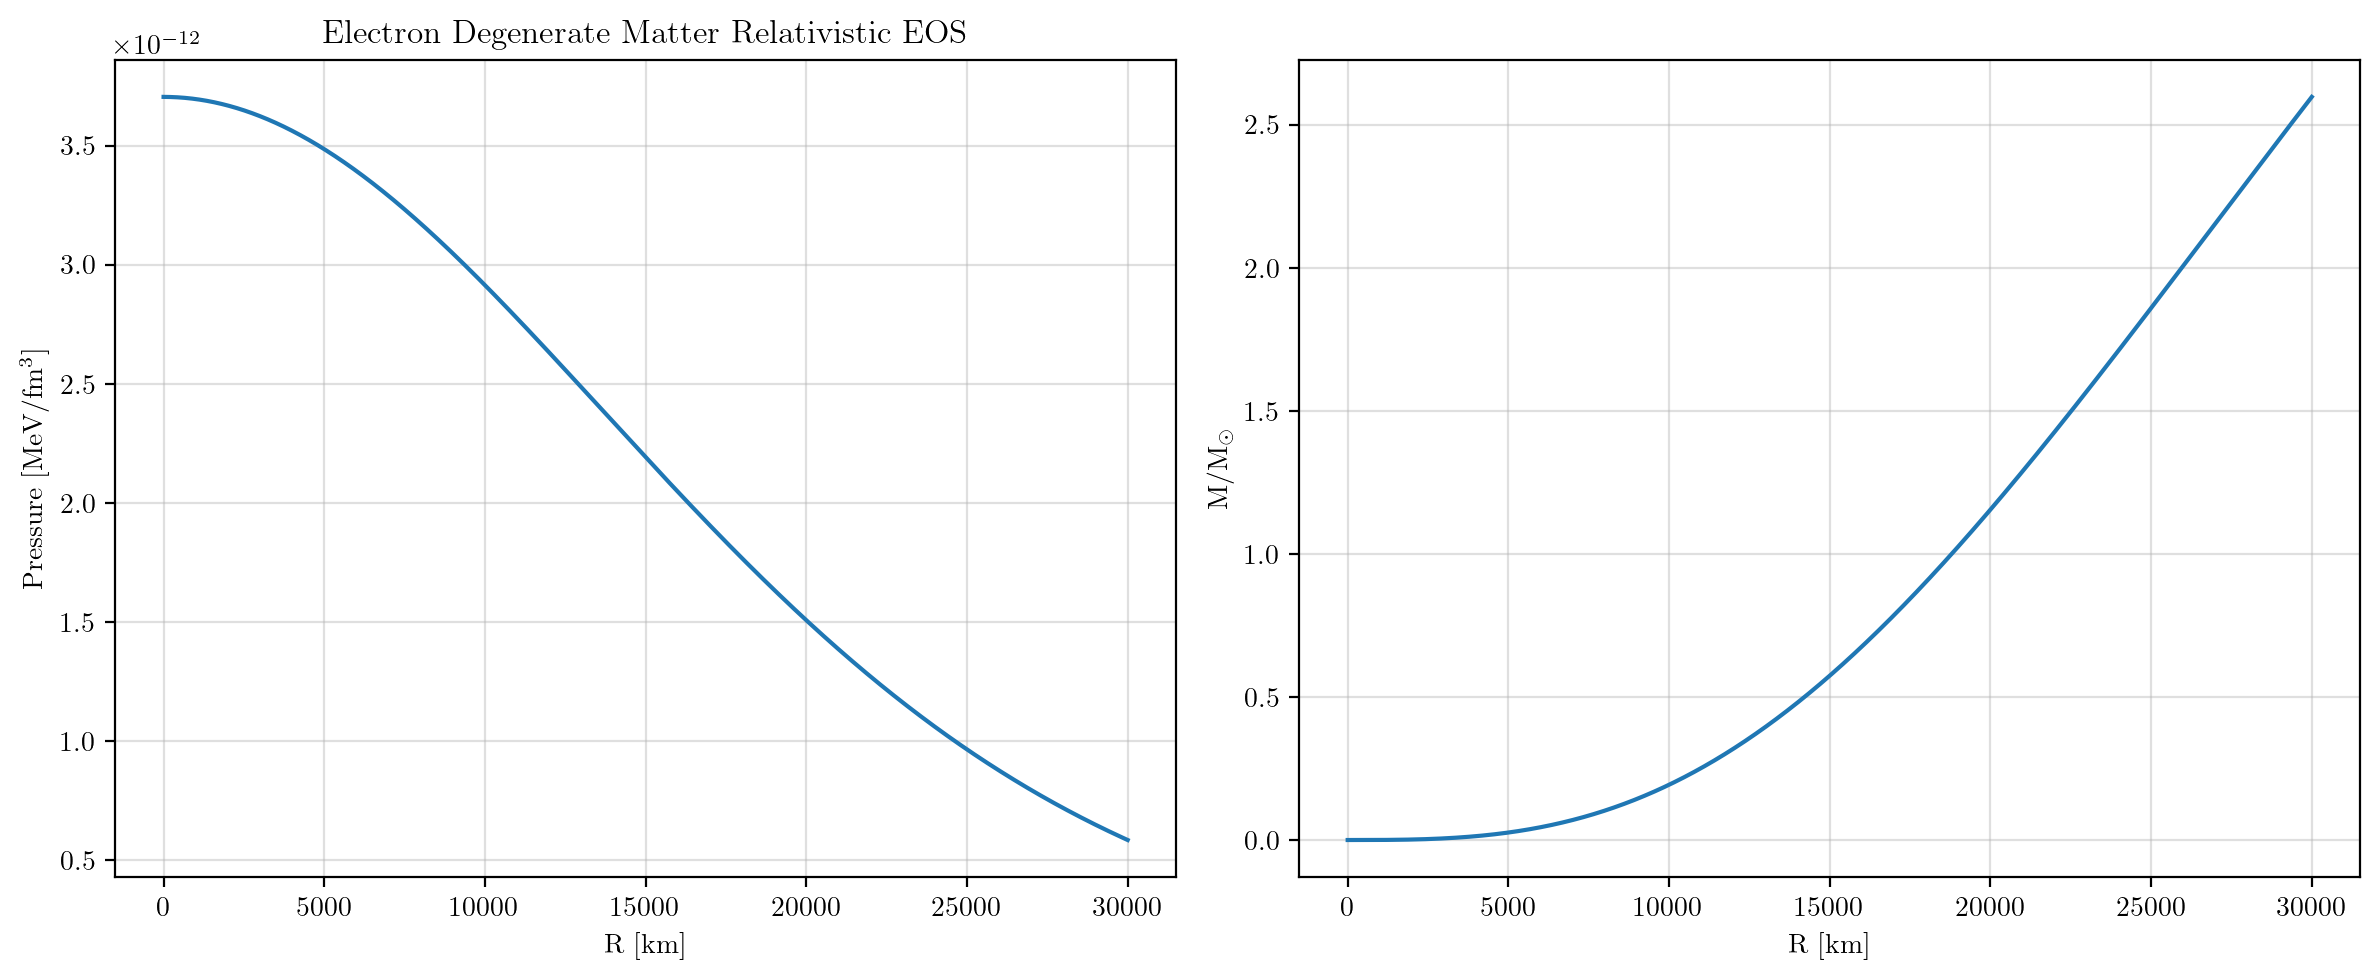

In [58]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------
R_0 = (G * M_sun / c**2).to(u.km)  # in km

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def R_TOV_electron_matter(x,r):
    p, M = x
    if p < 0:
        # avoid negative pressure during integration
        return [0, 0]

    term1 = R_0.value * (p/K_R)**(1/gamma_R) * M / r**2
    term2 = 1 + p**(1-1/gamma_R) * K_R**(1/gamma_R)
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0.value * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = alpha * r**2 * (p/K_R)**(1/gamma_R)

    return [dpdr, dMdr]



# ----------------------------------------------------
# Initial conditions
# ----------------------------------------------------

central_pressure =  p_R_EOS_electron_matter(central_energy)

r0 = 0.1             
central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
x0 = [central_pressure, central_mass]   # p(r0), M(r0)
deltar = 0.1
radius = np.arange(r0, 2000000, deltar)  # integra llarg

sol = odeint(R_TOV_electron_matter, x0, radius)

pressure = sol[:,0]
mass = sol[:,1]

R_surface = radius[np.where(pressure <= 0)[0][0]]  # first index where pressure <= 0
P_surface = pressure[np.where(pressure <= 0)[0][0]]  #stores the state vector at the event
M_surface = mass[np.where(pressure <= 0)[0][0]]  #stores the state vector at the event
print("Surface radius:", R_surface)
print("Pressure at surface:", P_surface)   # Should be exactly 0
print("Mass at surface:", M_surface)

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(radius[:300000], pressure[:300000]*e_0)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV/fm$^3$]")
plt.title("Electron Degenerate Matter Relativistic EOS")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius[:300000], mass[:300000])
plt.xlabel("R [km]")
plt.ylabel("M/M$_\odot$")
plt.grid()

plt.tight_layout()
plt.show()



Maximum mass of a white dwarf is 1.4M0, and radius should be Earth-like $\sim 7000$ km. So it's clearly wrong

⚠ WARNING: No zero-pressure surface for central_energy = 1e-15
  Final pressure: 1.8072832174386353e-22
⚠ WARNING: No zero-pressure surface for central_energy = 3.856620421163472e-15
  Final pressure: 1.9084095547240823e-22
⚠ WARNING: No zero-pressure surface for central_energy = 1.4873521072935117e-14
  Final pressure: 4.7719170806848076e-23
⚠ WARNING: No zero-pressure surface for central_energy = 5.736152510448681e-14
  Final pressure: 3.152487243856872e-26


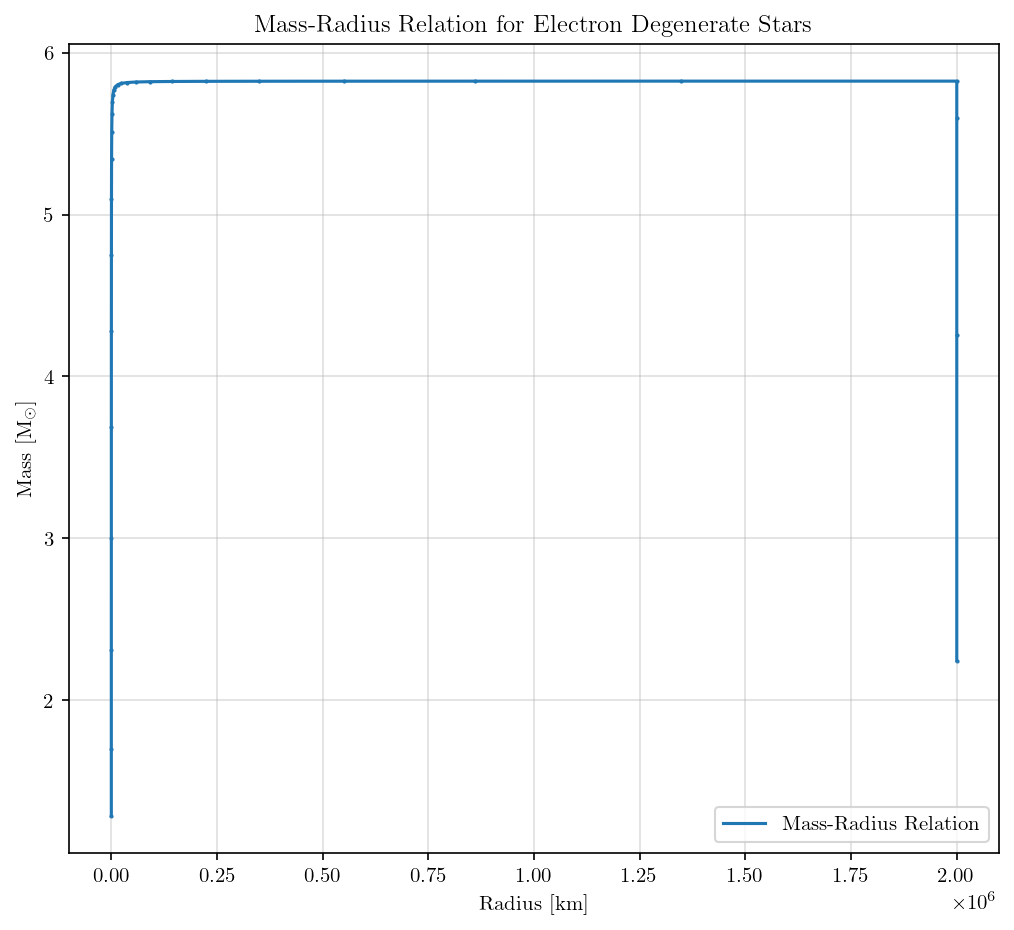

In [54]:
central_energies = np.logspace(-15, 2, 30)
def solve_TOV(central_energy):

    # Compute initial pressure from EOS
    central_pressure = p_R_EOS_electron_matter(central_energy)

    r0 = 0.1
    central_mass_density = (central_energy * e_0 / c**2 / M_sun).to(1/u.km**3)
    central_mass = (4/3)*np.pi*r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]

    # Radius grid for integration
    radius = np.arange(r0, 2e6, deltar)

    # Integrate
    sol = odeint(R_TOV_electron_matter, x0, radius)
    pressure = sol[:,0]
    mass     = sol[:,1]

    # ------------------------------------------------------
    # Find first radius where pressure <= 0
    # ------------------------------------------------------
    idx = np.where(pressure <= 0)[0]

    if len(idx) == 0:
        # No surface found → warn and return fallback
        print("⚠ WARNING: No zero-pressure surface for central_energy =", central_energy)
        print("  Final pressure:", pressure[-1])

        # Fallback = last integration point
        R_surface = radius[-1]
        M_surface = mass[-1]

        return R_surface, M_surface

    # ------------------------------------------------------
    # Surface found normally
    # ------------------------------------------------------
    i = idx[0]
    R_surface = radius[i]
    P_surface = pressure[i]
    M_surface = mass[i]

    # Optional warning if pressure is not exactly zero
    if abs(P_surface) > 1e-5:
        print("⚠ Pressure not exactly zero at surface:", P_surface*e_0)

    return R_surface, M_surface


radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label='Mass-Radius Relation')
plt.scatter(radii, masses, s=1)
plt.xlabel('Radius [km]')
plt.ylabel('Mass [M$_\odot$]')
plt.title('Mass-Radius Relation for Electron Degenerate Stars')
plt.grid()
plt.legend()
plt.show()


Central pressure: 2.488e+21 erg / cm3
Central pressure: 1.553e-12 MeV / fm3
Central pressure (adim): 1.034e-14
Central energy density: 7.948e-10 MeV / fm3
Central energy density: 5.290e-12 (adim)
Surface radius: 854261.8
Pressure at surface: -3.356634077139815e-33
Mass at surface: 5.82472916591448


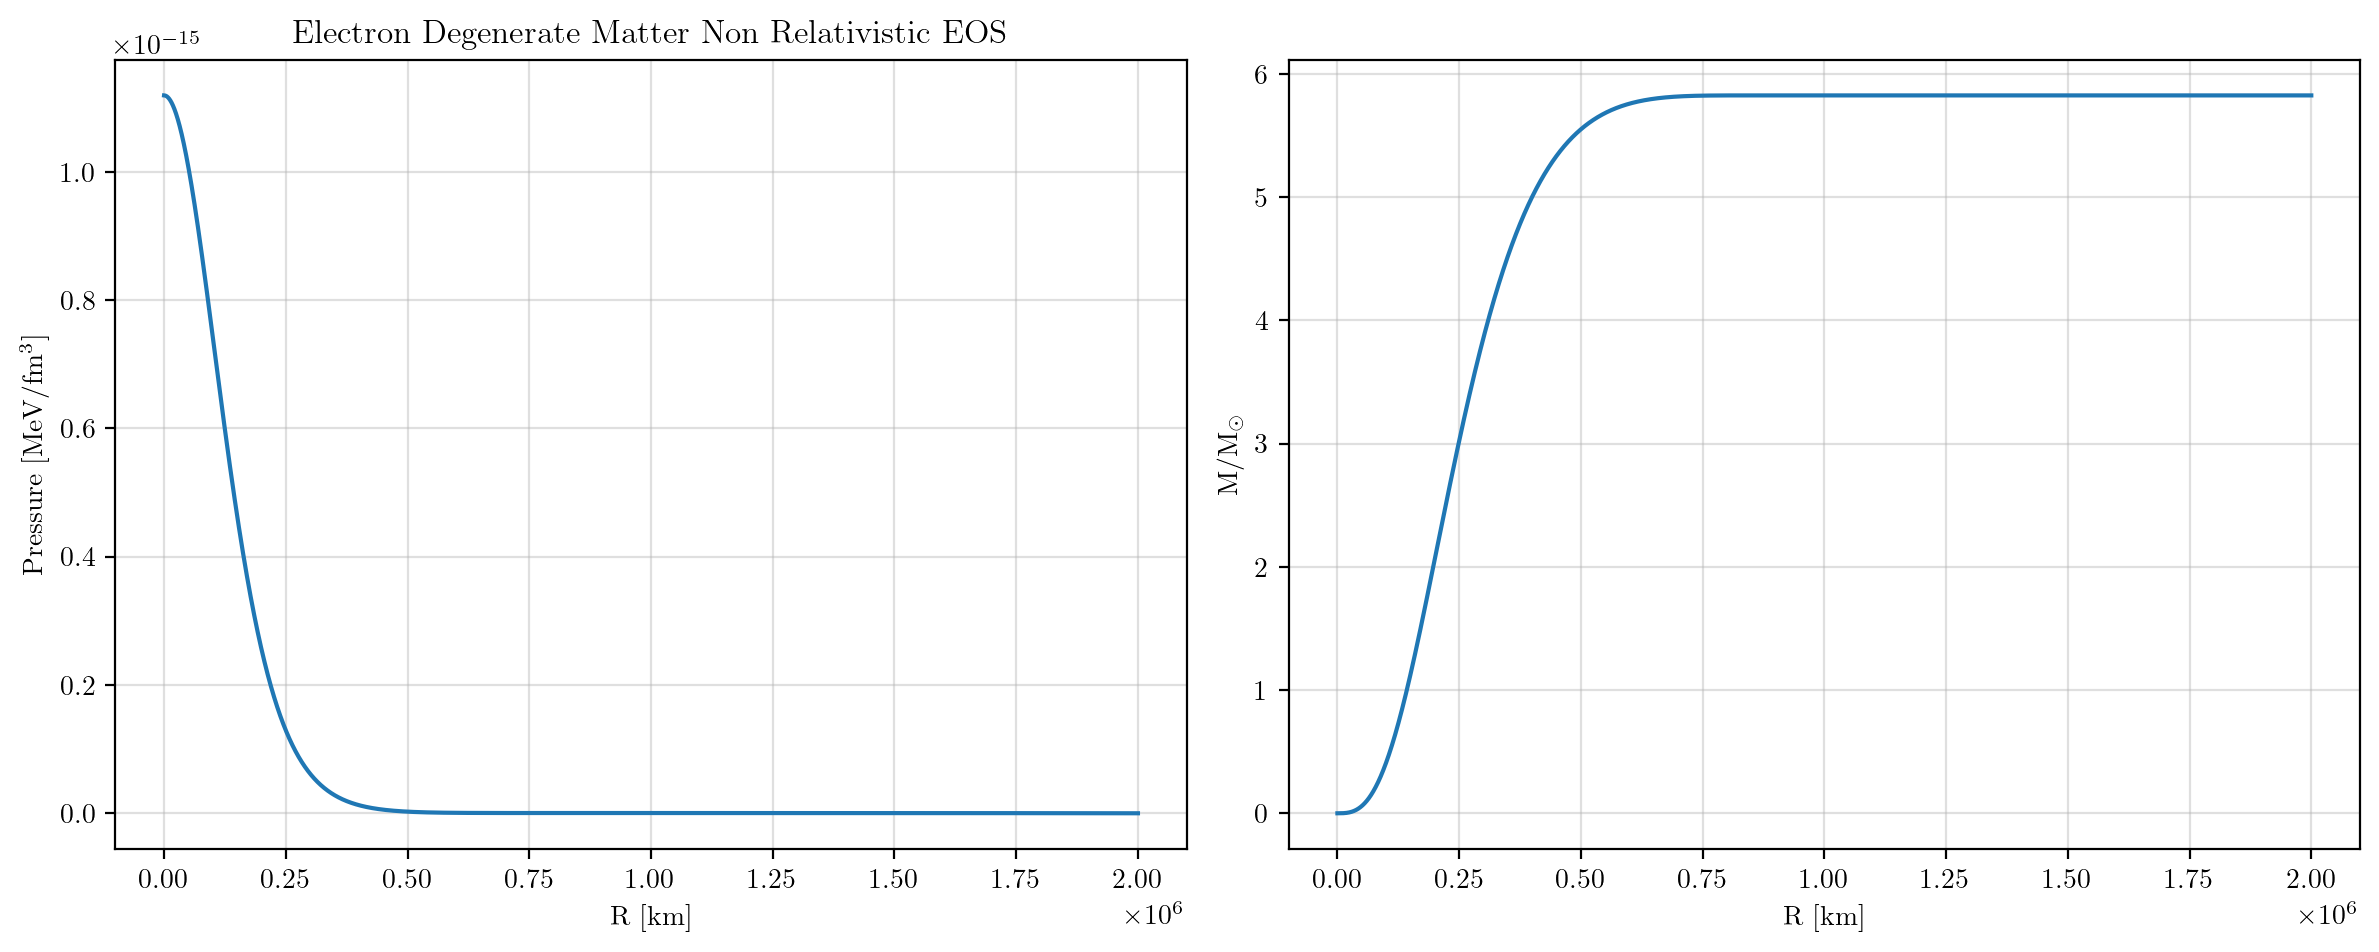

In [61]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------
R_0 = (G * M_sun / c**2).to(u.km)  # in km

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def NR_TOV_electron_matter(x,r):
    p, M = x
    if p < 0:
        # avoid negative pressure during integration
        return [0, 0]

    term1 = R_0.value * (p/K_NR)**(1/gamma_NR) * M / r**2
    term2 = 1 + p**(1-1/gamma_NR) * K_R**(1/gamma_NR)
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0.value * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = alpha * r**2 * (p/K_NR)**(1/gamma_NR)

    return [dpdr, dMdr]


# ----------------------------------------------------
# Initial conditions
# ----------------------------------------------------

pc= 1e-16 * 2.488* 10**37 * u.erg/u.cm**3  # central pressure
print(f"Central pressure: {pc:.3e}")
print(f"Central pressure: {pc.to('MeV/fm3'):.3e}")
central_pressure = (pc / e_0).decompose().value  # adimensional
print(f"Central pressure (adim): {central_pressure:.3e}")

central_energy = (central_pressure * K_R)**(1/gamma_R)
print(f"Central energy density: {central_energy * e_0:.3e}")
print(f"Central energy density: {central_energy:.3e} (adim)")

central_pressure =  p_NR_EOS_electron_matter(central_energy)

r0 = 0.1             
central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
x0 = [central_pressure, central_mass]   # p(r0), M(r0)
deltar = 0.1
radius = np.arange(r0, 2000000, deltar)  # integra llarg

sol = odeint(R_TOV_electron_matter, x0, radius)

pressure = sol[:,0]
mass = sol[:,1]

R_surface = radius[np.where(pressure <= 0)[0][0]]  # first index where pressure <= 0
P_surface = pressure[np.where(pressure <= 0)[0][0]]  #stores the state vector at the event
M_surface = mass[np.where(pressure <= 0)[0][0]]  #stores the state vector at the event
print("Surface radius:", R_surface)
print("Pressure at surface:", P_surface)   # Should be exactly 0
print("Mass at surface:", M_surface)

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(radius[:30000000], pressure[:30000000]*e_0)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV/fm$^3$]")
plt.title("Electron Degenerate Matter Non Relativistic EOS")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius[:30000000], mass[:30000000])
plt.xlabel("R [km]")
plt.ylabel("M/M$_\odot$")
plt.grid()

plt.tight_layout()
plt.show()

# Pure netron star


Following the same preocedure, they also derive two polytrope EOS valid in the relativistic and non relativistic regime:

Equation of state:

$$
p(\epsilon) = K \epsilon^\gamma
$$
Now with
$$
K_\text{NR} = \frac{\hbar^2}{15\pi^2m_n}\bigg(\frac{3 \pi^2 Z}{Am_nc^2}\bigg)^{5/3} \qquad K_\text{R} = \frac{1}{3}
$$
$$
\gamma_\text{NR} = \frac{5}{3} \qquad \gamma_\text{R} = 1 
$$


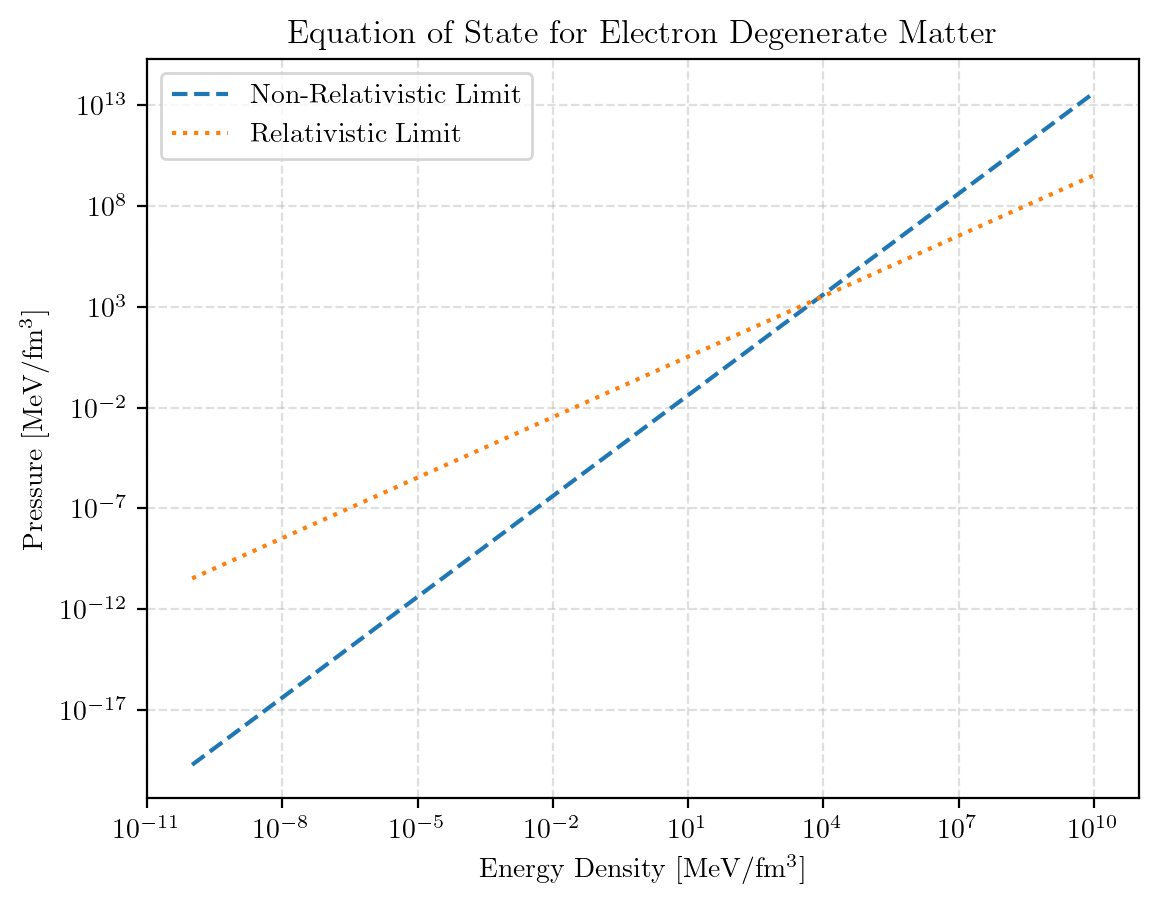

In [74]:
K_R  = 1/3
K_NR = (hbar ** 2 / 15 / np.pi**2 / m_n * ((3 * np.pi**2)/ (c**2 * m_n * AZ)) **(5/3)).to('fm2 / MeV**(2/3)')

def p_R_EOS_electron_matter(e):
    return K_R  * e

def p_NR_EOS_electron_matter(e):
    return K_NR * e ** (5/3)

e_vals = np.logspace(-10, 10, 1000) * u.MeV / u.fm**3
p_NR_vals = p_NR_EOS_electron_matter(e_vals)
p_R_vals  = p_R_EOS_electron_matter(e_vals)

plt.loglog(e_vals,p_NR_vals, '--', label='Non-Relativistic Limit')
plt.loglog(e_vals, p_R_vals, ':', label='Relativistic Limit')
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.title('Equation of State for Electron Degenerate Matter')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()


In [75]:
#---- Saturation density and energy density ----

n_0 = 0.16 * u.fm**-3 # saturation density
m_0 = 939 * u.MeV / c**2  # neutron mass
e_0 = n_0 * m_0 * c**2 # saturation energy density

gamma_R = 1
K_R = 1/3
print(f"K_R = {K_R:.3e}")

def p_R_EOS_neutron_matter(e):
    return K_R  * e


gamma_NR = 5/3
K_0_NR = e_0**(1-gamma_NR)
K_NR = K_NR/K_0_NR
def p_NR_EOS_neutron_matter(e):
    return K_NR * e ** (5/3)
print(f"K_NR = {K_NR:.3e}")

K_R = 3.333e-01
K_NR = 2.487e-02


In [76]:
# their central pressure is 10^-16
pc= 0.01 * 5.346 * 10**36 * u.erg/u.cm**3  # central pressure
#print(f"Central pressure: {pc:.3e}")
print(f"Central pressure: {pc.to('MeV/fm3'):.3e}")
central_pressure = (pc / e_0).decompose().value  # adimensional
print(f"Central pressure (adim): {central_pressure:.3e}")

central_energy = (central_pressure * K_R)**(1/gamma_R)
print(f"Central energy density: {central_energy * e_0:.3e}")
print(f"Central energy density: {central_energy:.3e} (adim)")

Central pressure: 3.337e+01 MeV / fm3
Central pressure (adim): 2.221e-01
Central energy density: 1.112e+01 MeV / fm3
Central energy density: 7.403e-02 (adim)


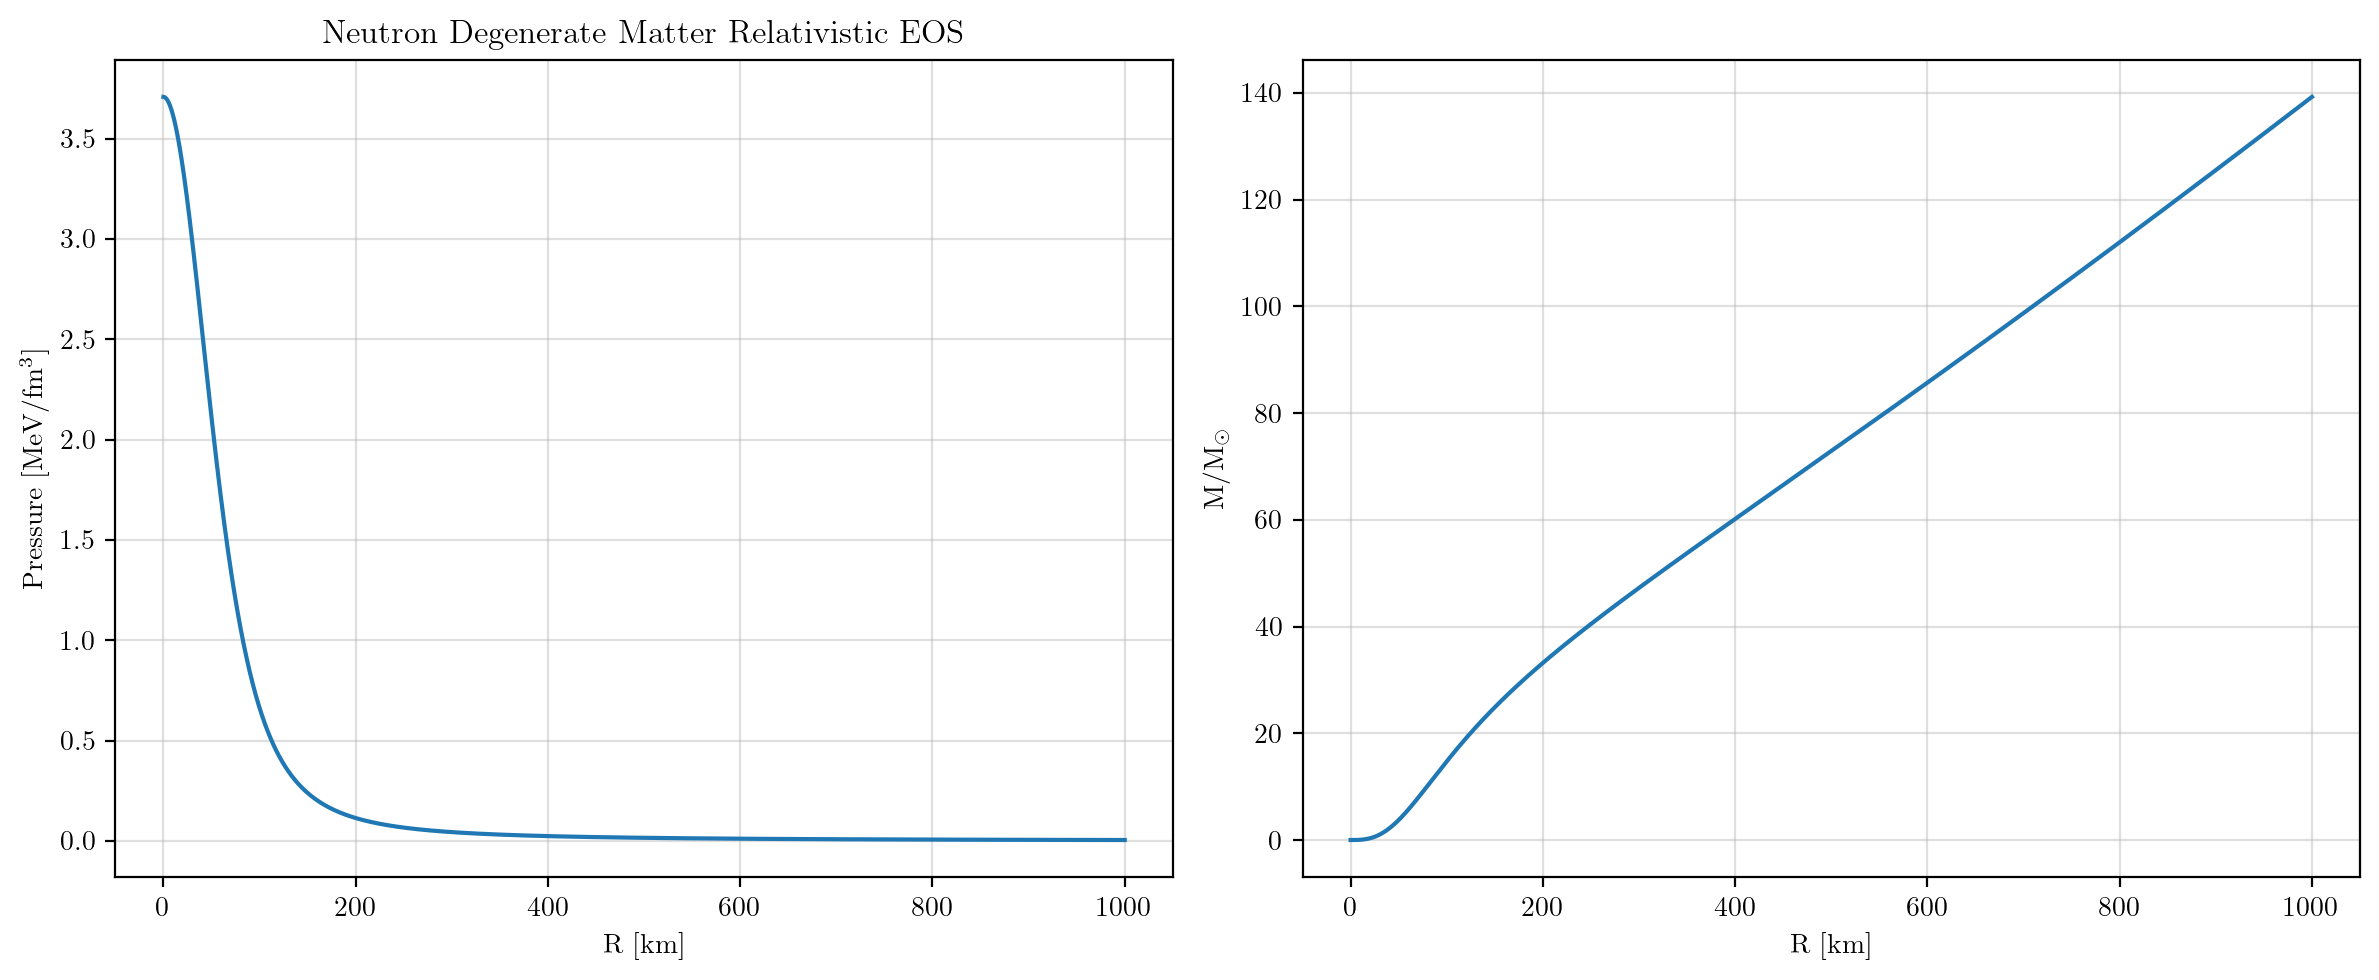

In [77]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def R_TOV_neutron_matter(x,r):
    p, M = x
    if p < 0:
        # avoid negative pressure during integration
        return [0, 0]

    term1 = R_0.value * (p/K_R)**(1/gamma_R) * M / r**2
    term2 = 1 + p**(1-1/gamma_R) * K_R**(1/gamma_R)
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0.value * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = alpha * r**2 * (p/K_R)**(1/gamma_R)

    return [dpdr, dMdr]



# ----------------------------------------------------
# Initial conditions
# ----------------------------------------------------

central_pressure =  p_R_EOS_neutron_matter(central_energy)

r0 = 0.1             
central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
x0 = [central_pressure, central_mass]   # p(r0), M(r0)
deltar = 0.1
radius = np.arange(r0, 2000000, deltar)  # integra llarg
    
sol = odeint(R_TOV_electron_matter, x0, radius)

pressure = sol[:,0]
mass = sol[:,1]

#R_surface = radius[np.where(pressure <= 0)[0][0]]  # first index where pressure <= 0
#P_surface = pressure[np.where(pressure <= 0)[0][0]]  #stores the state vector at the event
#M_surface = mass[np.where(pressure <= 0)[0][0]]  #stores the state vector at the event
#print("Surface radius:", R_surface)
#print("Pressure at surface:", P_surface)   # Should be exactly 0
#print("Mass at surface:", M_surface)

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(radius[:5000*2], pressure[:5000*2]*e_0)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV/fm$^3$]")
plt.title("Neutron Degenerate Matter Relativistic EOS")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius[:5000*2], mass[:5000*2])
plt.xlabel("R [km]")
plt.ylabel("M/M$_\odot$")
plt.grid()

plt.tight_layout()
plt.show()



For this EOS, the solution of $p(r)$ falls monotonically to zero at infinite. Never reaching a solution

Central pressure: 1.001e+03 MeV / fm3
Central pressure (adim): 6.659e+00
Central energy density: 3.335e+02 MeV / fm3
Central energy density: 2.220e+00 (adim)
Surface radius: 14.6
Pressure at surface: -2.9787160283038936e-10
Mass at surface: 0.5787640546814181


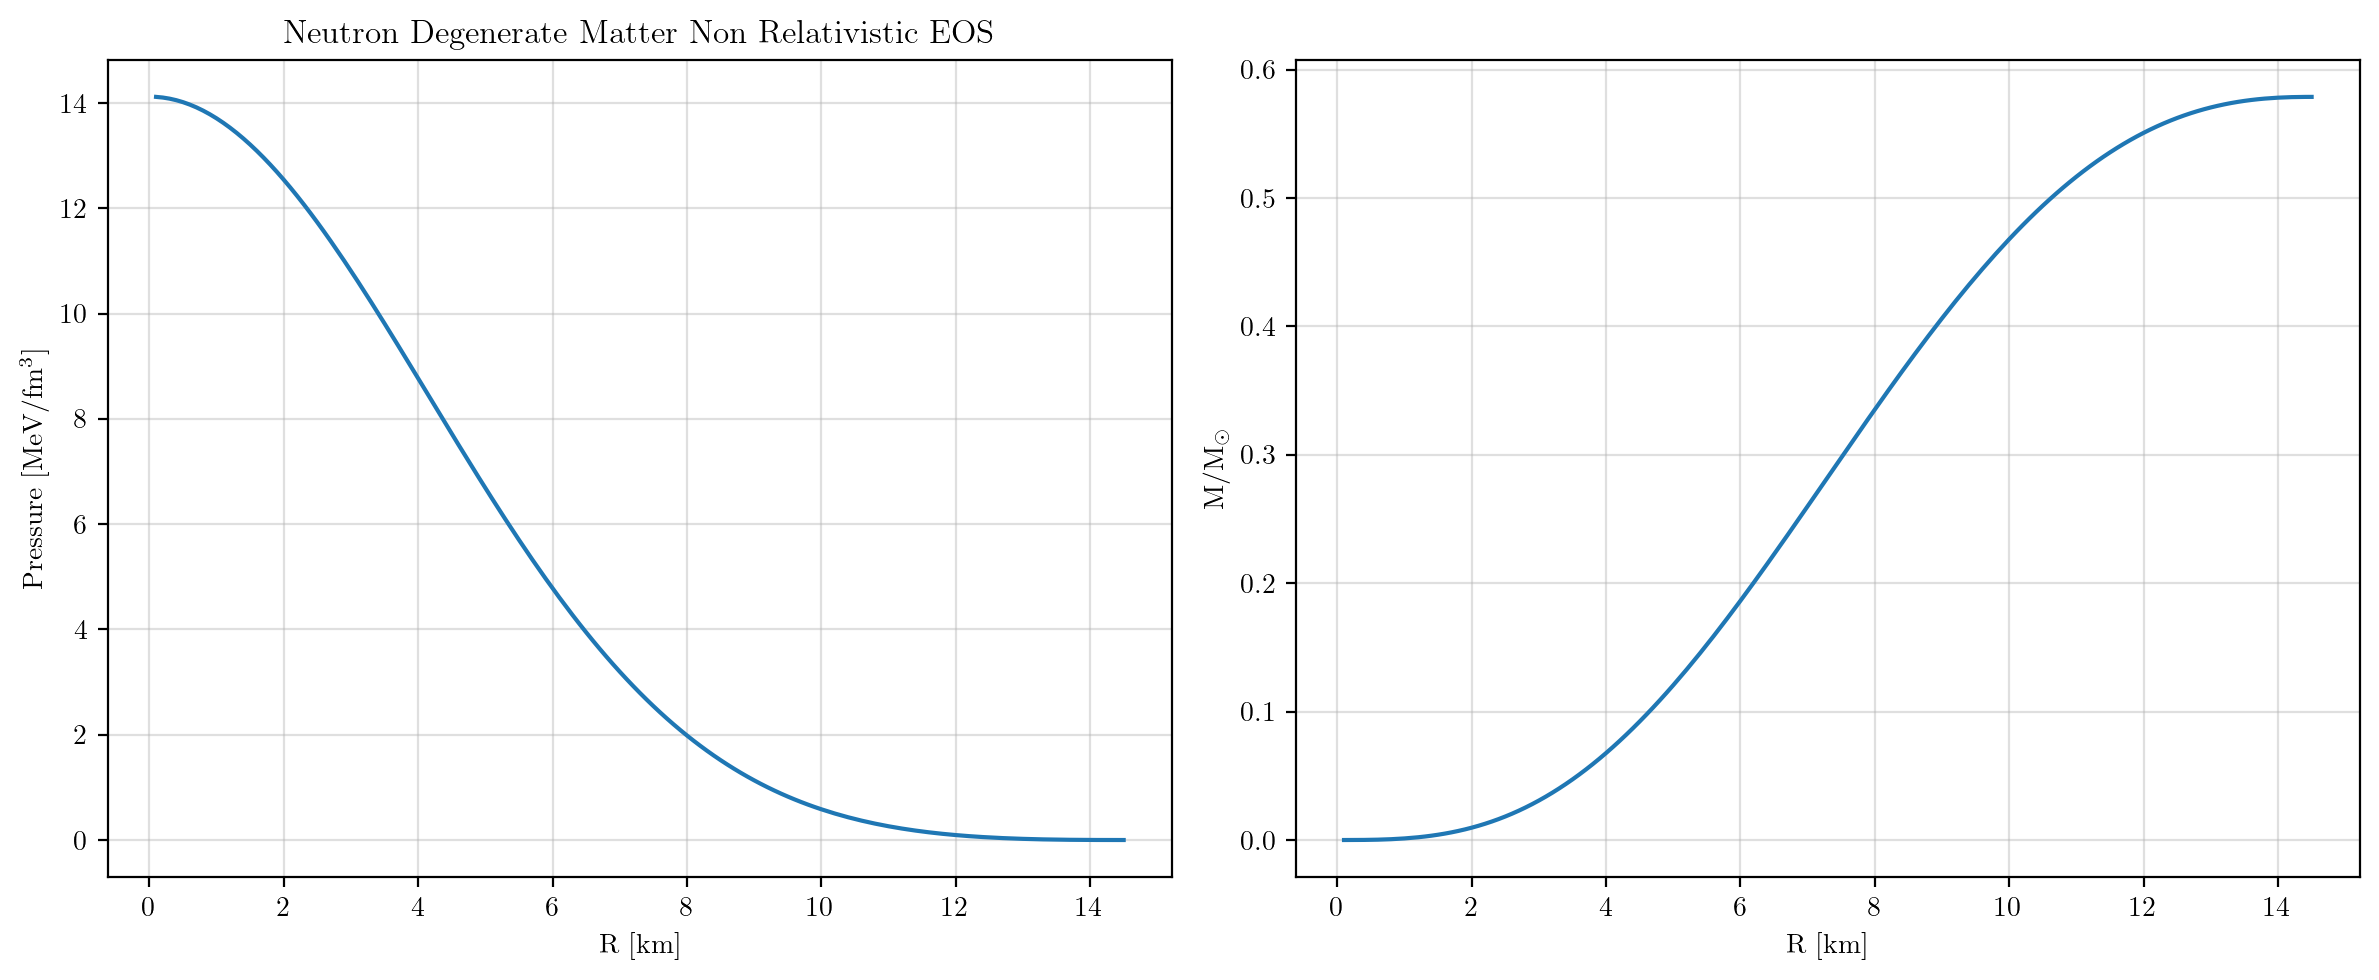

In [83]:
# their central pressure is 10^-16
pc= 0.01 * 1.603* 10**38 * u.erg/u.cm**3  # central pressure
#print(f"Central pressure: {pc:.3e}")
print(f"Central pressure: {pc.to('MeV/fm3'):.3e}")
central_pressure = (pc / e_0).decompose().value  # adimensional
print(f"Central pressure (adim): {central_pressure:.3e}")

central_energy = (central_pressure * K_R)**(1/gamma_R)
print(f"Central energy density: {central_energy * e_0:.3e}")
print(f"Central energy density: {central_energy:.3e} (adim)")


# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def NR_TOV_neutron_matter(x,r):
    p, M = x
    if p < 0:
        # avoid negative pressure during integration
        return [0, 0]

    term1 = R_0.value * (p/K_NR)**(1/gamma_NR) * M / r**2
    term2 = 1 + p**(1-1/gamma_NR) * K_NR**(1/gamma_NR)
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0.value * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = alpha * r**2 * (p/K_NR)**(1/gamma_NR)

    return [dpdr, dMdr]



# ----------------------------------------------------
# Initial conditions
# ----------------------------------------------------

central_pressure =  p_NR_EOS_neutron_matter(central_energy)

r0 = 0.1             
central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
x0 = [central_pressure, central_mass]   # p(r0), M(r0)
deltar = 0.1
radius = np.arange(r0, 2000000, deltar)  # integra llarg
    
sol = odeint(NR_TOV_electron_matter, x0, radius)

pressure = sol[:,0]
mass = sol[:,1]

R_surface = radius[np.where(pressure <= 0)[0][0]]  # first index where pressure <= 0
P_surface = pressure[np.where(pressure <= 0)[0][0]]  #stores the state vector at the event
M_surface = mass[np.where(pressure <= 0)[0][0]]  #stores the state vector at the event
print("Surface radius:", R_surface)
print("Pressure at surface:", P_surface)   # Should be exactly 0
print("Mass at surface:", M_surface)

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))
#plot until reaches zero pressure
plt.subplot(1,2,1)
plt.plot(radius[:np.where(pressure <= 0)[0][0]], pressure[:np.where(pressure <= 0)[0][0]]*e_0)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV/fm$^3$]")
plt.title("Neutron Degenerate Matter Non Relativistic EOS")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius[:np.where(pressure <= 0)[0][0]], mass[:np.where(pressure <= 0)[0][0]])
plt.xlabel("R [km]")
plt.ylabel("M/M$_\odot$")
plt.grid()

plt.tight_layout()
plt.show()

For this EOS, the results matches the expected results

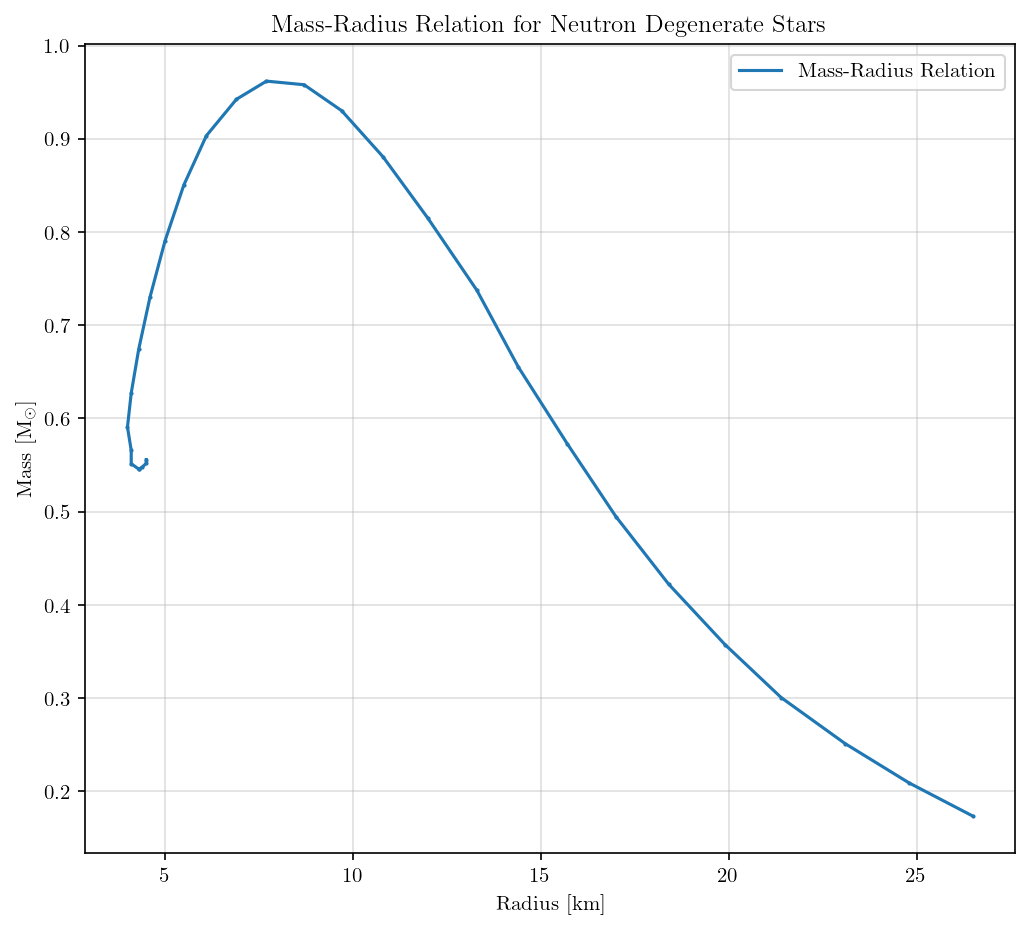

In [94]:
central_energies = np.logspace(-1, 4, 30)
def solve_TOV(central_energy):

    # Compute initial pressure from EOS
    central_pressure = p_NR_EOS_neutron_matter(central_energy)

    r0 = 0.1
    central_mass_density = (central_energy * e_0 / c**2 / M_sun).to(1/u.km**3)
    central_mass = (4/3)*np.pi*r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]

    # Radius grid for integration
    radius = np.arange(r0, 2e6, deltar)

    # Integrate
    sol = odeint(NR_TOV_neutron_matter, x0, radius)
    pressure = sol[:,0]
    mass     = sol[:,1]

    # ------------------------------------------------------
    # Find first radius where pressure <= 0
    # ------------------------------------------------------
    idx = np.where(pressure <= 0)[0]

    if len(idx) == 0:
        # No surface found → warn and return fallback
        print(" WARNING: No zero-pressure surface for central_energy =", central_energy)
        print("  Final pressure:", pressure[-1])

        # Fallback = last integration point
        R_surface = radius[-1]
        M_surface = mass[-1]

        return R_surface, M_surface

    # ------------------------------------------------------
    # Surface found normally
    # ------------------------------------------------------
    i = idx[0]
    R_surface = radius[i]
    P_surface = pressure[i]
    M_surface = mass[i]

    # Optional warning if pressure is not exactly zero
    if abs(P_surface) > 1e-5:
        print("Pressure not exactly zero at surface:", P_surface*e_0)

    return R_surface, M_surface


radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label='Mass-Radius Relation')
plt.scatter(radii, masses, s=1)
plt.xlabel('Radius [km]')
plt.ylabel('Mass [M$_\odot$]')
plt.title('Mass-Radius Relation for Neutron Degenerate Stars')
plt.grid()
plt.legend()
plt.show()

Using their values to see if it matches exactly

In [ ]:
A_NR = 2.4216


def e(p):
    return A_NR * p**(3/5)

e_0 = 5.346 * 10 **36 * u.erg/u.cm**3
gamma_NR = 5/3
gamma_R = 1

alpha = R_0.value
beta = 0.03778


# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def NR_TOV_neutron_matter(x,r):
    p, M = x
    if p < 0:
        return [0, 0]

    term1 = R_0.value * (p/K_NR)**(1/gamma_NR) * M / r**2
    term2 = 1 + p**(1-1/gamma_NR) * K_NR**(1/gamma_NR)
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0.value * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = beta * r**2 * (p)**(1/gamma_NR)

    return [dpdr, dMdr]

In [ ]:
A_NR = 2.4216
A_R = 2.8663



def e(p):
    return A_NR * p**(3/5) + A_R * p
e_0= 5.346 * 10 **36 * u.erg/u.cm**3
gamma_NR = 5/3
gamma_R = 1

alpha = R_0.value
beta = 0.03778


# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def NR_TOV_neutron_matter(x,r):
    p, M = x
    if p < 0:
        return [0, 0]

    term1 = R_0.value * (p/K_NR)**(1/gamma_NR) * M / r**2
    term2 = 1 + p**(1-1/gamma_NR) * K_NR**(1/gamma_NR)
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0.value * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = beta * r**2 * (p)**(1/gamma_NR)

    return [dpdr, dMdr]